In [4]:
import environ

env = environ.Env()
environ.Env.read_env()
#Todo only load the repo folder
DataSetsPath     = env('DataSetsPath')     #* get the path of the script
ModelsPath       = env('ModelsPath')       #* get the path of the script
FitFunctionsPath = env('FitFunctionsPath') #* get the path of the script
root_Data        = env('DataSet_Dogs_Vs_catsPath')         #* get the path of the dataSet of the fist 12_000 img of https://www.kaggle.com/c/dogs-vs-cats
root_Data_Val    = env('DataSet_Dogs_Vs_catsValPath')      #* get the path of the dataSet of the last 500 img of https://www.kaggle.com/c/dogs-vs-cats
model_save_dir   = env('model_save_dir')   #* get the path where we will save the model


import sys
sys.path.append(DataSetsPath)
sys.path.append(ModelsPath)
sys.path.append(FitFunctionsPath)


import torch
import torchvision.transforms as transforms
from DataSets.dataSet_CatsVsDogs import DataSet_Img_To_Label
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"
print("device = ", device) #todo 

device =  cpu


In [5]:
image_Height   = 300
image_Width    = 300
image_Channels = 3
batch_size     = 64


In [6]:

from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, RandomSampler


data_augmentation = transforms.Compose([
                        #* Compose = compoues a list of function
                        transforms.ToPILImage(),
                        transforms.Resize((image_Height, image_Width)),
                        transforms.RandomRotation(degrees=5),  # Randomly rotate the image by up to 5 degrees
                                        
                        #* ToPILImage = cahnge the data type from PyTorch tensor or a NumPy ndarray to : A PIL (Python Imaging Library)
                        # transforms.RandomVerticalFlip(),
                        # transforms.RandomHorizontalFlip(),
                        # transforms.RandomRotation(degrees=15),  
                        transforms.ToTensor(), 
                        #* change the data type from Numpy or PIL to tensor
                        ])


myDataSet     = DataSet_Img_To_Label(root_Data,     data_augmentation, test = False, dataSize = 1000)
myDataSetVal  = DataSet_Img_To_Label(root_Data_Val, data_augmentation, test = False, dataSize = 100) 
#TODO make the validation dataSet

print("myDataSet     = ", myDataSet)
print("myDataSetVal = ", myDataSetVal)
my_Data_Loader      = DataLoader(myDataSet  , batch_size = batch_size, num_workers = 0,  shuffle = True) # sampler = random_sampler = RandomSampler(myDataSet) 
my_Data_Loader_Val = DataLoader(myDataSetVal, batch_size = batch_size, num_workers = 0,  shuffle = True)


myDataSet     =  len(dataSet) =  24000
dataSet[0]   =  ('cat.0.jpg', 1)

myDataSetVal =  len(dataSet) =  1000
dataSet[0]   =  ('cat.12000.jpg', 1)



In [7]:
import matplotlib.pyplot as plt
import numpy as np
from Models.models_CatsVsDogs import modelCNN
from Models.models_CatsVsDogs import modelSiLU


# myModel = Cnn()
# myModel = modelCNN()
myModel = modelSiLU(HEIGHT = image_Height, WIDTH = image_Width, CHANNELS = image_Channels)
myModel.to(device = device)

# print(myModel.state_dict().keys())
# weights = myModel.state_dict()['conv_1.weight']

# # Get the number of filters and channels
# num_filters = weights.shape[0]
# num_channels = weights.shape[1]

# # Create subplots for each filter
# fig, axs = plt.subplots(num_filters, num_channels, figsize=(10, 10))

# # Plot each filter
# for i in range(num_filters):
#     for j in range(num_channels):
#         axs[i, j].imshow(weights[i, j].cpu().detach().numpy(), cmap='viridis')
#         axs[i, j].axis('off')

# plt.tight_layout()
# plt.show()



modelSiLU(
  (Sect_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Sect_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Sect_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flat_1): Linear(in_features=1600, out_features=10, bias=True)
  (SiLU): SiLU()
  (dens_1): Sequential(
    (0):

In [10]:
import importlib
import FitFunctions.fitFunctionsForCatsVsDogs

importlib.reload(FitFunctions.fitFunctionsForCatsVsDogs)

#* test train_modelCNN
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from FitFunctions.fitFunctionsForCatsVsDogs import train_modelCNN


opt_model = optim.Adam(myModel.parameters(), lr = 0.001)
# criterion = nn.BCELoss()
# criterion = torch.nn.MSELoss()
criterion = nn.CrossEntropyLoss()

history = train_modelCNN(my_Data_Loader, 
                        myModel, 
                        opt_model, 
                        device      = device, 
                        num_epochs  = 10,
                        get_History = True, 
                        criterion   = criterion, 
                        getVal      = True, 
                        data_loader_Val = my_Data_Loader_Val,
                        model_save_dir  = model_save_dir)
# print(myModel.state_dict().keys())
# weights = myModel.state_dict()['dens_1.4.weight']



Epoch 1/10 process: 99: 100%|██████████| 375/375 [01:53<00:00,  3.31it/s, modelLoss=0.353]


Epoch completed, Average Loss in TRAIN (MAE): 0.5260
Epoch completed, Average accuracy in TRAIN (ACC): 0.7319
Epoch completed, MAE in VAL: 0.4404
Epoch completed, ACC in VAL: 0.8040


Epoch 2/10 process: 99: 100%|██████████| 375/375 [02:04<00:00,  3.02it/s, modelLoss=0.535]


Epoch completed, Average Loss in TRAIN (MAE): 0.4255
Epoch completed, Average accuracy in TRAIN (ACC): 0.8037
Epoch completed, MAE in VAL: 0.3897
Epoch completed, ACC in VAL: 0.8310


Epoch 3/10 process: 99: 100%|██████████| 375/375 [01:51<00:00,  3.37it/s, modelLoss=0.418]


Epoch completed, Average Loss in TRAIN (MAE): 0.3788
Epoch completed, Average accuracy in TRAIN (ACC): 0.8278
Epoch completed, MAE in VAL: 0.3778
Epoch completed, ACC in VAL: 0.8350


Epoch 4/10 process: 99: 100%|██████████| 375/375 [01:53<00:00,  3.30it/s, modelLoss=0.396]


Epoch completed, Average Loss in TRAIN (MAE): 0.3478
Epoch completed, Average accuracy in TRAIN (ACC): 0.8450
Epoch completed, MAE in VAL: 0.3432
Epoch completed, ACC in VAL: 0.8420


Epoch 5/10 process: 99: 100%|██████████| 375/375 [01:51<00:00,  3.37it/s, modelLoss=0.333]


Epoch completed, Average Loss in TRAIN (MAE): 0.3166
Epoch completed, Average accuracy in TRAIN (ACC): 0.8604
Epoch completed, MAE in VAL: 0.3999
Epoch completed, ACC in VAL: 0.8220


Epoch 6/10 process: 99: 100%|██████████| 375/375 [01:53<00:00,  3.32it/s, modelLoss=0.385]


Epoch completed, Average Loss in TRAIN (MAE): 0.2965
Epoch completed, Average accuracy in TRAIN (ACC): 0.8727
Epoch completed, MAE in VAL: 0.3408
Epoch completed, ACC in VAL: 0.8590


Epoch 7/10 process: 99: 100%|██████████| 375/375 [02:00<00:00,  3.11it/s, modelLoss=0.333]


Epoch completed, Average Loss in TRAIN (MAE): 0.2732
Epoch completed, Average accuracy in TRAIN (ACC): 0.8840
Epoch completed, MAE in VAL: 0.3398
Epoch completed, ACC in VAL: 0.8500


Epoch 8/10 process: 99: 100%|██████████| 375/375 [01:56<00:00,  3.23it/s, modelLoss=0.195]


Epoch completed, Average Loss in TRAIN (MAE): 0.2594
Epoch completed, Average accuracy in TRAIN (ACC): 0.8891
Epoch completed, MAE in VAL: 0.4938
Epoch completed, ACC in VAL: 0.8070


Epoch 9/10 process: 99: 100%|██████████| 375/375 [01:54<00:00,  3.27it/s, modelLoss=0.36] 


Epoch completed, Average Loss in TRAIN (MAE): 0.2466
Epoch completed, Average accuracy in TRAIN (ACC): 0.8965
Epoch completed, MAE in VAL: 0.3265
Epoch completed, ACC in VAL: 0.8540


Epoch 10/10 process: 99: 100%|██████████| 375/375 [01:52<00:00,  3.33it/s, modelLoss=0.389] 


Epoch completed, Average Loss in TRAIN (MAE): 0.2299
Epoch completed, Average accuracy in TRAIN (ACC): 0.9037
Epoch completed, MAE in VAL: 0.3742
Epoch completed, ACC in VAL: 0.8470


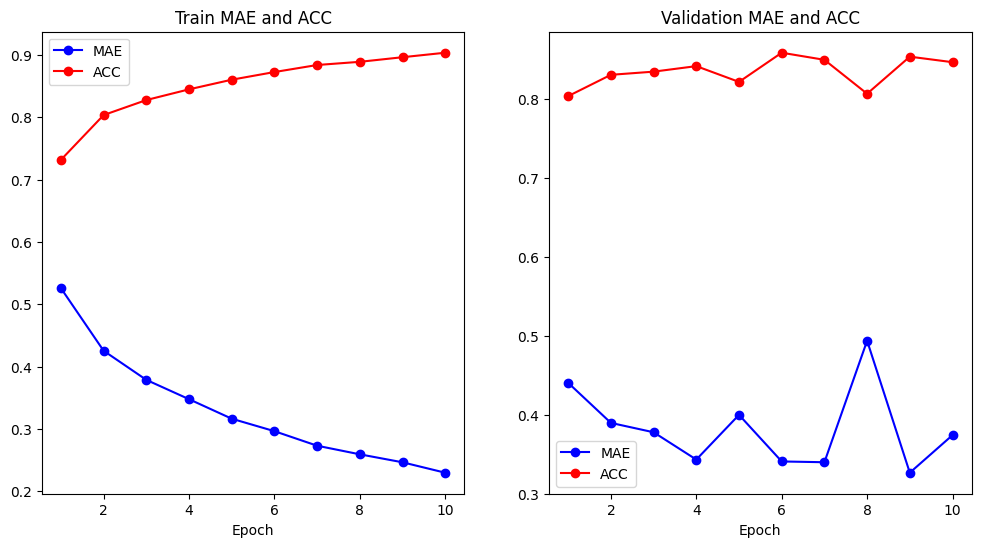

In [11]:
import matplotlib.pyplot as plt

Epochs_values     = range(1, len(history['train_MAE']) + 1)
Epochs_values_Val = range(1, len(history['train_MAE']) + 1)


# Create two subplots (one for MAE and one for MAE_Val) in a single row
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot MAE and ACC in train at the first subplot
plt1.plot(Epochs_values,     history['train_MAE'], marker='o', color='blue', label='MAE')
plt1.plot(Epochs_values_Val, history['train_ACC'], marker='o', color='red', label='ACC')
# plt1.set_ylabel('train MAE and ACC')
plt1.set_xlabel('Epoch')
plt1.set_title('Train MAE and ACC')

# Plot MAE and ACC in validation at the second subplot
plt2.plot(Epochs_values,     history['val_MAE'], marker='o', color='blue', label='MAE')
plt2.plot(Epochs_values_Val, history['val_ACC'], marker='o', color='red', label='ACC')
# plt2.set_ylabel('MAE and ACC')
plt2.set_xlabel('Epoch')
plt2.set_title('Validation MAE and ACC')


# Add legend to each subplot
plt1.legend()
plt2.legend()



# Show the plots
plt.show()


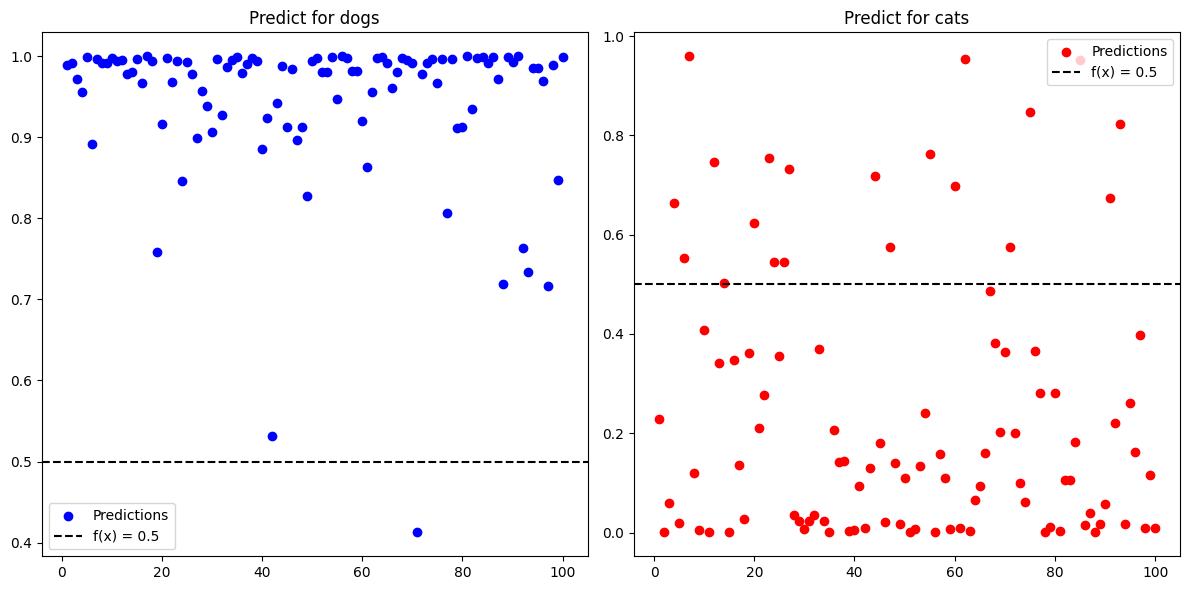

In [12]:
import numpy as np
import os
from PIL import Image

img_pth = root_Data + '/'

dog_paths = ['dog.' + str(i) + '.jpg' for i in range(0, 100)]
cat_paths = ['cat.' + str(i) + '.jpg' for i in range(0, 100)]

def getArrayBatch(paths):

    tensor_batch = []
    for path in paths:
        img  = os.path.join(img_pth + path)
        img  = np.array(Image.open(img))
        img  = img [:, :, :3]
        img = data_augmentation(img)
        tensor_batch.append(img)

    tensor_batch = torch.stack(tensor_batch).to(device)
    tensor_batch = myModel(tensor_batch)
    tensor_batch = torch.softmax(tensor_batch, dim=1)[:, 0].cpu().detach().numpy()  # Extract probability for the positive class
    # tensor_batch = tensor_batch.cpu().detach().numpy()
    return tensor_batch

predict_Array_dogs = getArrayBatch(dog_paths)
predict_Array_cats = getArrayBatch(cat_paths)

import matplotlib.pyplot as plt

num_images_dogs     = range(1, len(predict_Array_dogs) + 1)
num_images_cats = range(1, len(predict_Array_dogs) + 1)

fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(12, 6))

#* Plot points for dogs
plt1.scatter(num_images_dogs, predict_Array_dogs, marker='o', color='blue', label = 'Predictions')
plt1.set_title('Predict for dogs')

#* Plot points for cats
plt2.scatter(num_images_cats, predict_Array_cats, marker='o', color='red', label = 'Predictions')
plt2.set_title('Predict for cats')

#* Add horizontal line at y=0.5
plt1.axhline(y=0.5, color='black', linestyle='--', label='f(x) = 0.5')
plt2.axhline(y=0.5, color='black', linestyle='--', label='f(x) = 0.5')

#* Add legends
plt1.legend()
plt2.legend()

plt.tight_layout()
plt.show()



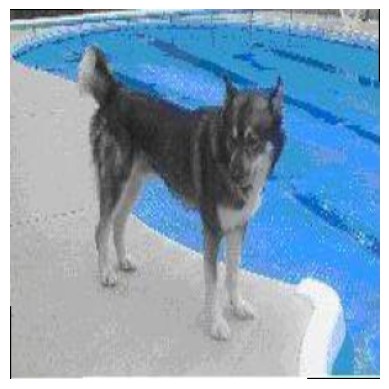

array([0.7926335], dtype=float32)

In [13]:
#TODO use the model 
import os 
from PIL import Image

img_pth = root_Data_Val + '/dog.12403.jpg' 

img  = os.path.join(img_pth)
img  = np.array(Image.open(img))
img  = img [:, :, :3]
img  = data_augmentation(img)


img_array = img.permute(1, 2, 0).numpy()  # Assuming the tensor is of shape [3, height, width]
# Plot the image
img = img.unsqueeze(0)
plt.imshow(img_array)
plt.axis('off')  # Turn off axis
plt.show()

torch.softmax(myModel(img.to(device)), dim=1)[:, 0].cpu().detach().numpy()
